In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder


In [8]:
train_df = pd.read_parquet('../Data/Data files/train_data.parquet')
test_df = pd.read_parquet('../Data/Data files/submission_data.parquet')

train_df.shape

(2812490, 20)

### Data exploration

In [4]:
#Check for general data description
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
phase,2812490.0,0.048643,0.057644,0.000000,0.005526,0.034504,0.066429,0.920948
dayweek,2812490.0,2.021754,1.433430,0.000000,1.000000,2.000000,3.000000,6.000000
month,2812490.0,6.555709,3.395726,1.000000,4.000000,7.000000,9.000000,12.000000
wd_perc,2812490.0,0.524532,0.288327,0.037037,0.272727,0.523810,0.772727,1.000000
hospital_rate,2307496.0,0.245473,0.373138,0.000000,0.001108,0.028945,0.343298,1.000000
n_nwd_bef,2812490.0,0.622881,1.461790,0.000000,0.000000,0.000000,0.000000,23.000000
n_nwd_aft,2812490.0,0.377534,1.010696,0.000000,0.000000,0.000000,0.000000,20.000000
n_weekday_0,2812490.0,5.922095,2.769304,2.000000,4.000000,5.000000,8.000000,15.000000
n_weekday_1,2812490.0,6.251577,2.830125,2.000000,4.000000,5.000000,8.000000,15.000000
n_weekday_2,2812490.0,6.257275,2.849015,2.000000,4.000000,5.000000,8.000000,15.000000


In [5]:
# Seek for missing values
train_df.isnull().sum()

brand                 0
phase                 0
country               0
dayweek               0
month                 0
wd_perc               0
ther_area        356445
hospital_rate    504994
n_nwd_bef             0
n_nwd_aft             0
n_weekday_0           0
n_weekday_1           0
n_weekday_2           0
n_weekday_3           0
n_weekday_4           0
date                  0
wd                    0
wd_left               0
monthly               0
main_channel     504994
dtype: int64

In [6]:
train_df.groupby(["country", "brand"]).agg({"phase" : ["sum", "mean", "median", "std"]})

phase                              
                sum      mean    median       std
country brand                                    
Aldovia AIMST  99.0  0.048482  0.041122  0.037204
        AITPJ  48.0  0.048780  0.042265  0.032662
        AIZTT  69.0  0.048936  0.035104  0.050120
        AMOKR  49.0  0.048276  0.036229  0.043541
        BELQI   1.0  0.052632  0.051314  0.060728
...             ...       ...       ...       ...
Zamunda ZHQFB  40.0  0.048193  0.037438  0.046373
        ZKKLD  76.0  0.048223  0.036406  0.049768
        ZKMVW  86.0  0.047964  0.028659  0.056230
        ZNDRT  57.0  0.048305  0.037484  0.047313
        ZVLFE  45.0  0.048232  0.038487  0.043308

[2684 rows x 4 columns]

### Feature engineering

In [21]:
# Extracting the date from the datetime column
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['quarter_of_year'] = train_df['date'].dt.quarter

##### Lag features

In [27]:
def random_noise(dataframe):
    return np.random.normal(scale=1.5, size=(len(dataframe),))

In [33]:
def lag_features(dataframe, lag_list):
    for lag in lag_list:
        s = str(lag[0]) + "_" + lag[1]
        if lag[1] == 'day':
            dataframe['date_' + s] = dataframe['date'] - pd.Timedelta(days=lag[0])
        elif lag[1] == 'month':
            dataframe['date_' + s] = dataframe['date'] - pd.offsets.MonthBegin(n=lag[0])
        
        if 'phase_lag_' + s in dataframe.columns:
            dataframe.drop(['phase_lag_' + s], axis=1, inplace=True)

        dataframe = dataframe.merge(dataframe[['brand', 'country', 'date', 'phase']], 
                     left_on=['brand', 'country', 'date_' + s], 
                     right_on=['brand', 'country', 'date'], 
                     suffixes=('', '_lag_' + s), 
                     how='left')
        
        
        
        dataframe.drop(['date_' + s, 'date_lag_' + s], axis=1, inplace=True)
        dataframe['phase_lag_' + s].fillna(0, inplace=True)
        
        # Add random noise to the lagged feature
        #dataframe['phase_lag_' + s] = dataframe['phase_lag_' + s].fillna(0) + random_noise(dataframe)
        
        
    return dataframe

In [34]:
train_df.sort_values(by=['country', 'brand', 'date'], inplace=True)

train_df = lag_features(train_df, [[1, 'day'], [2, 'day'], [3, 'day'], [7, 'day'], [14, 'day']])

In [ ]:
train_df[train_df['country'] == 'Aldovia'][train_df['brand'] == 'AIMST'][0:50][['date', 'phase', 'phase_lag_1_day', 'phase_lag_2_day', 'phase_lag_3_day', 'phase_lag_7_day', 'phase_lag_14_day']]


C:\Users\Guim\AppData\Local\Temp\ipykernel_2180\3073336127.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[train_df['country'] == 'Aldovia'][train_df['brand'] == 'AIMST'][0:50][['date', 'phase', 'phase_lag_1_day', 'phase_lag_2_day', 'phase_lag_3_day', 'phase_lag_7_day', 'phase_lag_14_day']]


,date,phase,phase_lag_1_day,phase_lag_2_day,phase_lag_3_day,phase_lag_7_day,phase_lag_14_day
0,2013-01-02,0.006284,-0.628325,0.026261,0.989589,1.121315,-2.053098
1,2013-01-03,0.123459,2.167079,-1.964719,-1.677815,-2.853318,2.170990
2,2013-01-04,0.055607,0.402824,0.984818,1.556599,-2.145477,1.089936
3,2013-01-07,0.032148,0.650684,0.779163,2.591189,3.298608,1.314394
4,2013-01-08,0.097054,0.533241,0.162456,0.960981,0.962858,-0.875224
5,2013-01-09,0.042682,2.809754,0.378490,0.877564,1.218349,-0.275199
6,2013-01-10,0.022866,0.002923,2.960830,2.059368,2.170469,-1.153697
7,2013-01-11,0.042612,0.706673,-0.702205,-0.454240,0.762737,1.643992
8,2013-01-14,0.050981,-1.400700,0.088090,-0.829717,1.132255,-1.116952
9,2013-01-15,0.061581,1.529461,-1.287974,0.527764,-1.909913,-1.331191


In [97]:
train_df[train_df['country'] == 'Aldovia'][train_df['brand'] == 'AIMST'][222:]

C:\Users\guimc\AppData\Local\Temp\ipykernel_20460\841047330.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[train_df['country'] == 'Aldovia'][train_df['brand'] == 'AIMST']


,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,n_weekday_0,n_weekday_1,n_weekday_2,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel
0,AIMST,0.006284,Aldovia,2.0,1.0,0.045455,NaN,NaN,4.0,0.0,4,4,5,5,4,2013-01-02,1,21,0.008092,NaN
1,AIMST,0.123459,Aldovia,3.0,1.0,0.090909,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-03,2,20,0.008092,NaN
2,AIMST,0.055607,Aldovia,4.0,1.0,0.136364,NaN,NaN,0.0,2.0,4,4,5,5,4,2013-01-04,3,19,0.008092,NaN
3,AIMST,0.032148,Aldovia,0.0,1.0,0.181818,NaN,NaN,2.0,0.0,4,4,5,5,4,2013-01-07,4,18,0.008092,NaN
4,AIMST,0.097054,Aldovia,1.0,1.0,0.227273,NaN,NaN,0.0,0.0,4,4,5,5,4,2013-01-08,5,17,0.008092,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,AIMST,0.029592,Aldovia,0.0,12.0,0.809524,NaN,NaN,2.0,0.0,3,4,4,5,5,2021-12-27,17,4,0.003069,NaN
2038,AIMST,0.042513,Aldovia,1.0,12.0,0.857143,NaN,NaN,0.0,0.0,3,4,4,5,5,2021-12-28,18,3,0.003069,NaN
2039,AIMST,0.011557,Aldovia,2.0,12.0,0.904762,NaN,NaN,0.0,0.0,3,4,4,5,5,2021-12-29,19,2,0.003069,NaN
2040,AIMST,0.000000,Aldovia,3.0,12.0,0.952381,NaN,NaN,0.0,0.0,3,4,4,5,5,2021-12-30,20,1,0.003069,NaN


In [93]:
train_df[222:]

,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,...,n_weekday_3,n_weekday_4,date,wd,wd_left,monthly,main_channel,day,year,phase_lag_7
222,AIMST,0.092071,Aldovia,0.0,12,0.882353,NaN,NaN,2.0,3.0,...,3,3,2013-12-23,15,2,0.003956,NaN,23,2013,0.031177
223,AIMST,0.073341,Aldovia,4.0,12,0.941176,NaN,NaN,3.0,2.0,...,3,3,2013-12-27,16,1,0.003956,NaN,27,2013,0.009301
224,AIMST,0.000000,Aldovia,0.0,12,1.000000,NaN,NaN,2.0,2.0,...,3,3,2013-12-30,17,0,0.003956,NaN,30,2013,0.092071
225,AIMST,0.046161,Aldovia,3.0,1,0.047619,NaN,NaN,2.0,0.0,...,5,5,2014-01-02,1,20,0.004222,NaN,2,2014,0.000000
226,AIMST,0.028132,Aldovia,4.0,1,0.095238,NaN,NaN,0.0,3.0,...,5,5,2014-01-03,2,19,0.004222,NaN,3,2014,0.073341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2812485,ZVLFE,0.010716,Zamunda,0.0,9,0.818182,M,NaN,2.0,0.0,...,5,5,2016-09-26,18,4,0.010540,NaN,26,2016,0.108942
2812486,ZVLFE,0.042210,Zamunda,1.0,9,0.863636,M,NaN,0.0,0.0,...,5,5,2016-09-27,19,3,0.010540,NaN,27,2016,0.002369
2812487,ZVLFE,0.051639,Zamunda,2.0,9,0.909091,M,NaN,0.0,0.0,...,5,5,2016-09-28,20,2,0.010540,NaN,28,2016,0.043872
2812488,ZVLFE,0.065464,Zamunda,3.0,9,0.954545,M,NaN,0.0,0.0,...,5,5,2016-09-29,21,1,0.010540,NaN,29,2016,0.101771


In [51]:

# Store categorical features for different treatment
cat_features = ['brand', 'country', 'ther_area', 'main_channel']
cat_used_features = ['brand', 'country']
num_used_features = ['day', 'month', 'year', 'phase_lag_7']

# Splitting the data into X and y
X_df = train_df[num_used_features + cat_used_features]
y_df = train_df['phase']


In [52]:


# Split the data into training and testing sets based on the year
X_train_df = X_df[X_df['year'] == 2020]
y_train = y_df[X_df['year'] == 2020]
X_test_df = X_df[X_df['year'] >= 2021]
y_test = y_df[X_df['year'] >= 2021]

C:\Users\guimc\AppData\Local\Temp\ipykernel_20460\1796053513.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_df[X_train_df['country'] == 'Dorne'][X_train_df['brand'] == 'ICPTW'].head(n=60)


,day,month,year,phase_lag_7,brand,country
1052661,2,1,2020,0.015917,ICPTW,Dorne
1052662,3,1,2020,0.085856,ICPTW,Dorne
1052663,6,1,2020,0.050507,ICPTW,Dorne
1052664,7,1,2020,0.000000,ICPTW,Dorne
1052665,8,1,2020,0.000000,ICPTW,Dorne
1052666,9,1,2020,0.000000,ICPTW,Dorne
1052667,10,1,2020,0.000000,ICPTW,Dorne
1052668,13,1,2020,0.000000,ICPTW,Dorne
1052669,14,1,2020,0.000000,ICPTW,Dorne
1052670,15,1,2020,0.069726,ICPTW,Dorne


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2812490 entries, 0 to 3525881
Data columns (total 23 columns):
 #   Column         Dtype         
---  ------         -----         
 0   brand          object        
 1   phase          float64       
 2   country        object        
 3   dayweek        float64       
 4   month          int64         
 5   wd_perc        float64       
 6   ther_area      category      
 7   hospital_rate  float64       
 8   n_nwd_bef      float64       
 9   n_nwd_aft      float64       
 10  n_weekday_0    int64         
 11  n_weekday_1    int64         
 12  n_weekday_2    int64         
 13  n_weekday_3    int64         
 14  n_weekday_4    int64         
 15  date           datetime64[ns]
 16  wd             int64         
 17  wd_left        int64         
 18  monthly        float64       
 19  main_channel   category      
 20  day            int64         
 21  year           int64         
 22  phase_lag_7    float64       
dtypes: cate

In [4]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform on training data
X_train_encoded = encoder.fit_transform(X_train_df[['country', 'brand']])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['country', 'brand']))
X_train_combined = pd.concat([X_train_encoded_df, X_train_df[['day', 'month', 'year']].reset_index(drop=True)], axis=1)

# Transform the test data
X_test_encoded = encoder.transform(X_test_df[['country', 'brand']])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['country', 'brand']))
X_test_combined = pd.concat([X_test_encoded_df, X_test_df[['day', 'month', 'year']].reset_index(drop=True)], axis=1)


In [24]:
# Instantiate and train the model
model = RandomForestRegressor(n_estimators=50, min_samples_leaf=4, random_state=42, verbose=1, n_jobs=6)
model.fit(X_train_combined, y_train)


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  2.5min finished


RandomForestRegressor(min_samples_leaf=4, n_estimators=50, n_jobs=6,
                      random_state=42, verbose=1)

In [25]:
# Make predictions and evaluate
predictions = model.predict(X_test_combined)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: ", mse)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s


Mean Squared Error:  0.004227883160163199


[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.9s finished


In [27]:
def metric(df: pd.DataFrame) -> float:
    """Compute performance metric.

    :param df: Dataframe with target ('phase') and 'prediction', and identifiers.
    :return: Performance metric
    """
    df = df.copy()
    assert 'monthly' in df.columns, "Missing 'monthly' column, only available in the train set"
    assert 'phase' in df.columns, "Missing 'phase' column, only available in the train set"
    assert 'prediction' in df.columns, "Missing 'prediction' column with predictions"

    df["date"] = pd.to_datetime(df["date"])
    
    # create datetime columns
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter

    # Sum of phasing country-brand-month = 1
    df['sum_pred'] = df.groupby(['year', 'month', 'brand', 'country'])['prediction'].transform(sum)
    assert np.isclose(df['sum_pred'], 1.0, rtol=1e-04).all(), "Condition phasing year-month-brand-country must sum 1 is not fulfilled"
    
    # define quarter weights 
    df['quarter_w'] = np.where(df['quarter'] == 1, 1, 
                    np.where(df['quarter'] == 2, 0.75,
                    np.where(df['quarter'] == 3, 0.66, 0.5)))
                    
    # compute and return metric
    return round(np.sqrt((1 / len(df)) * sum(((df['phase'] - df['prediction'])**2) * df['quarter_w'] * df['monthly'])), 8)

In [28]:
train_df = pd.read_parquet('../Data/Data files/train_data.parquet')
df_train = train_df[train_df['date'].dt.year.isin([2021])]

df_val_predictions = pd.DataFrame({'phase': y_test, 'prediction': predictions, 'monthly': df_train['monthly'], 'date': df_train['date'], 'brand': X_test_df['brand'], 'country': X_test_df['country']})

In [49]:
performance_metric = metric(df_val_predictions)


print(f'Performance Metric: {performance_metric}')

Performance Metric: 0.01150094


In [16]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 306913 entries, 1789 to 3523152
Series name: phase
Non-Null Count   Dtype  
--------------   -----  
306913 non-null  float64
dtypes: float64(1)
memory usage: 4.7 MB


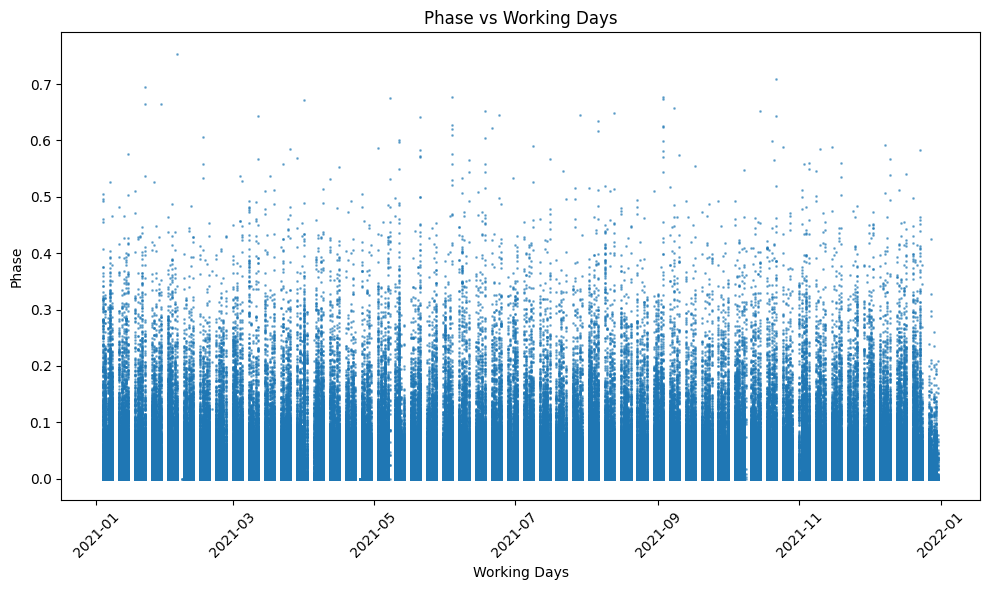

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(X_test_df['date'], y_test, marker='o', s=1, alpha=0.5)  # Adjusting marker size and transparency
plt.xlabel('Working Days')
plt.ylabel('Phase')
plt.title('Phase vs Working Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
X_test_df

,country,brand,day,month,year,date
1789,Aldovia,AIMST,4,1,2021,2021-01-04
1790,Aldovia,AIMST,5,1,2021,2021-01-05
1791,Aldovia,AIMST,7,1,2021,2021-01-07
1792,Aldovia,AIMST,8,1,2021,2021-01-08
1793,Aldovia,AIMST,11,1,2021,2021-01-11
...,...,...,...,...,...,...
3523148,Zamunda,ZKMVW,24,11,2021,2021-11-24
3523149,Zamunda,ZKMVW,25,11,2021,2021-11-25
3523150,Zamunda,ZKMVW,26,11,2021,2021-11-26
3523151,Zamunda,ZKMVW,29,11,2021,2021-11-29


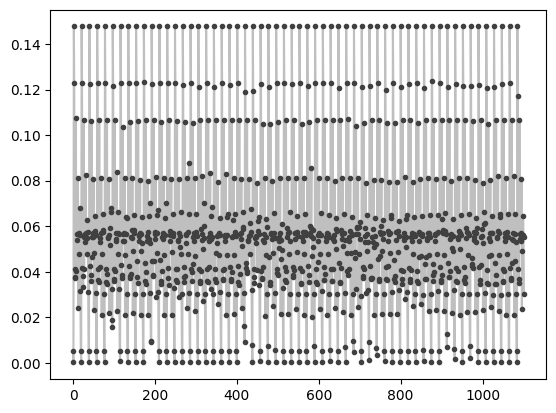

In [45]:

country = "Aldovia"

X_test_df_plot = X_test_df[X_test_df['country'] == country]
y_test_plot = y_test[X_test_df['country'] == country]
p_plot = predictions[X_test_df['country'] == country]

month = 1
indexes = X_test_df_plot['month'] == month
X_test_df_plot = X_test_df_plot[indexes]
y_test_plot = y_test_plot[indexes]
p_plot = p_plot[indexes]


plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = pd.DataFrame(p_plot).plot(**plot_params)
#ax = predictions.plot()